<a href="https://colab.research.google.com/github/fashjr/Plant-AI/blob/main/Copy_of_plants_seedling_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/plant/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/plant/Labels.csv')

In [ ]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


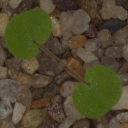

In [ ]:
cv2_imshow(images[15])

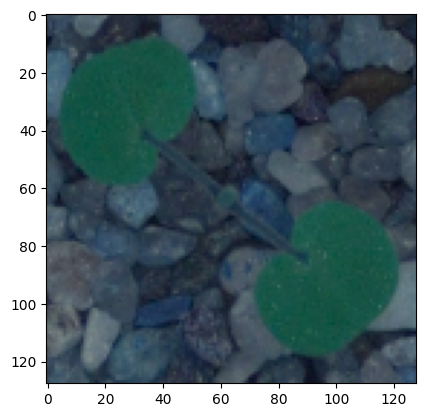

In [ ]:
plt.imshow(images[15]);

In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### EDA

In [ ]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

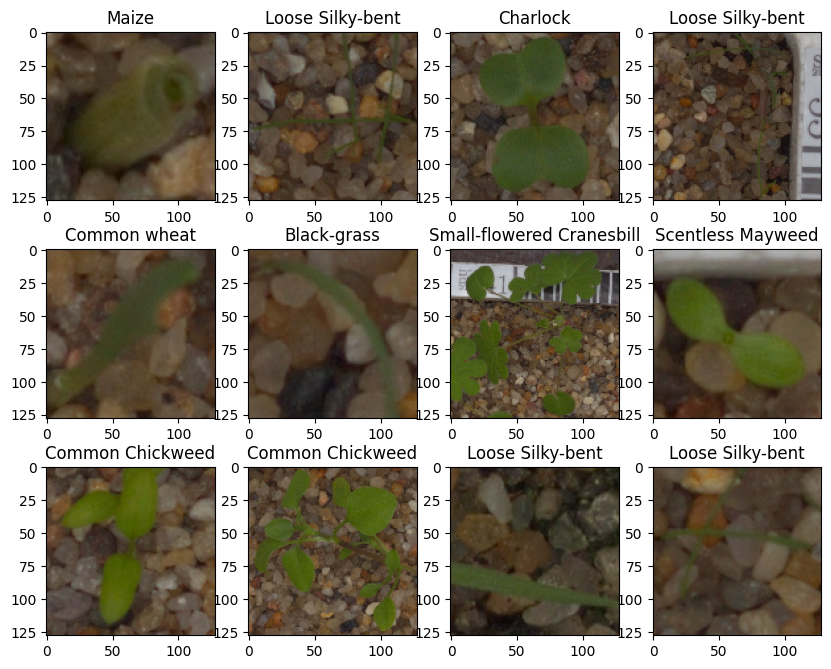

In [ ]:
plot_images(images,labels)

<b> Checking for data imbalance

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

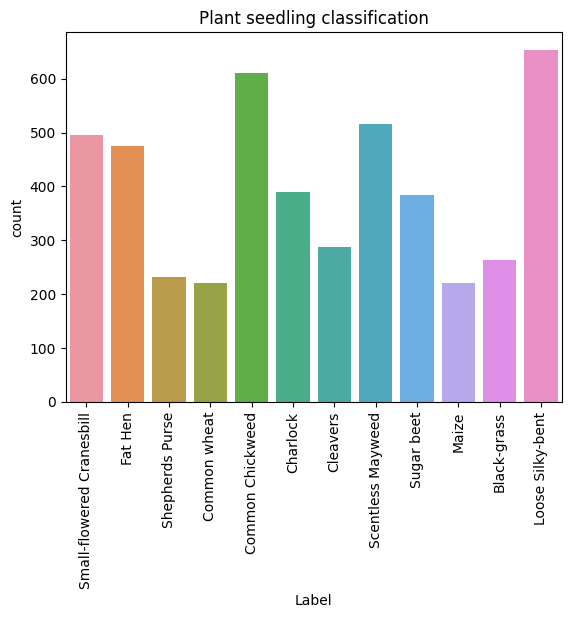

In [ ]:
 sns.countplot(x = 'Label', data=labels).set(title='Plant seedling classification')
 plt.xticks(rotation='vertical')

Resizing images

In [ ]:
images_decreased = []
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

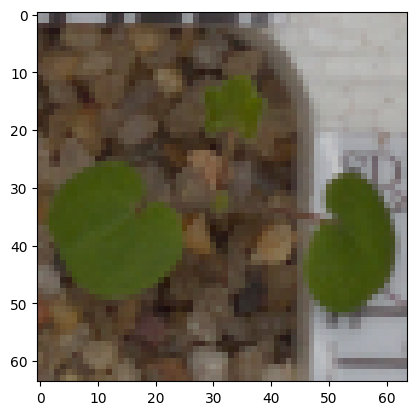

In [ ]:
plt.imshow(images_decreased[2])

## Data preprocessing

Visualizing images using Gaussian Blur

In [ ]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))


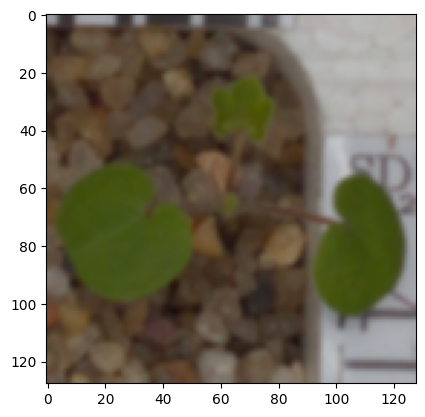

In [ ]:
plt.imshow(images_gb[2]);

GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

### Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Treating the class imbalance

In [ ]:
from sklearn.utils import class_weight

In [ ]:
labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.7974709784411277,
 1: 0.8348524305555556,
 2: 1.714349376114082,
 3: 1.7909683426443204,
 4: 0.6476430976430977,
 5: 1.0145042194092826,
 6: 1.3818247126436782,
 7: 0.7669457735247209,
 8: 1.0275106837606838,
 9: 1.7909683426443204,
 10: 1.5050860719874803,
 11: 0.604874213836478}

Making the data compatible:
- Convert labels from names to one hot vectors
- Normalizing the values

In [ ]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder


from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_val_encoded = lb.transform(y_val)
y_test_encoded = lb.transform(y_test)

### Data Normalization
Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## **Model 1**
## Model Building - Convolutional Neural Network (CNN)
Let's create a CNN model sequentially, where we will be adding the layers one after another.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model_2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
# Adding max pooling to reduce the size of output of first conv layer
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(64, activation='relu'))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model_2.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### <b> Fitting the model on the train data

In [ ]:
history_1 = model_2.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 18s - loss: 2.4265 - accuracy: 0.1476 - val_loss: 2.4251 - val_accuracy: 0.1379 - 18s/epoch - 146ms/step
Epoch 2/30
121/121 - 2s - loss: 2.3671 - accuracy: 0.1742 - val_loss: 2.0108 - val_accuracy: 0.3037 - 2s/epoch - 14ms/step
Epoch 3/30
121/121 - 2s - loss: 1.7346 - accuracy: 0.4032 - val_loss: 1.6255 - val_accuracy: 0.4416 - 2s/epoch - 14ms/step
Epoch 4/30
121/121 - 2s - loss: 1.4149 - accuracy: 0.5019 - val_loss: 1.3331 - val_accuracy: 0.5397 - 2s/epoch - 15ms/step
Epoch 5/30
121/121 - 2s - loss: 1.1800 - accuracy: 0.5947 - val_loss: 1.1018 - val_accuracy: 0.6238 - 2s/epoch - 15ms/step
Epoch 6/30
121/121 - 2s - loss: 0.9921 - accuracy: 0.6512 - val_loss: 1.0221 - val_accuracy: 0.6332 - 2s/epoch - 14ms/step
Epoch 7/30
121/121 - 2s - loss: 0.8542 - accuracy: 0.6886 - val_loss: 0.9123 - val_accuracy: 0.6799 - 2s/epoch - 13ms/step
Epoch 8/30
121/121 - 2s - loss: 0.7500 - accuracy: 0.7338 - val_loss: 0.9193 - val_accuracy: 0.6939 - 2s/epoch - 14ms/step
Epoch 9/30
12

### **Model Evaluation**

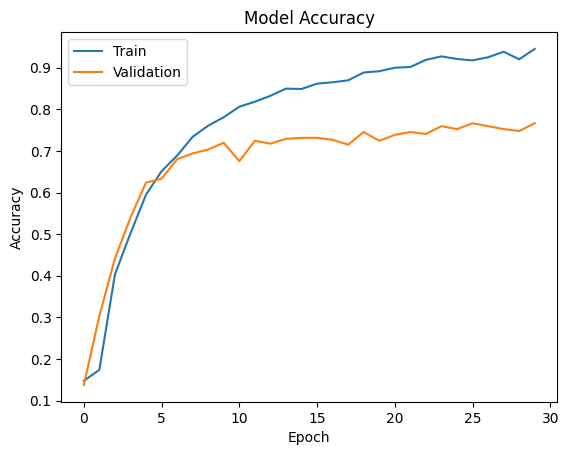

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**


*   We can see from the above plot that **the training accuracy of the  model was good but the validation accuracy was not as good.**
*   The model seems to overfit on the data.


### **Evaluating the model on test data**

In [ ]:
accuracy = model_2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.2353 - accuracy: 0.7600 - 365ms/epoch - 24ms/step


### **Generating the predictions using test data**

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model_2.predict(X_test_normalized)

15/15 [==============================] - 0s 5ms/step


In [ ]:
y_pred

array([[1.0667464e-30, 3.8917134e-28, 1.2007558e-18, ..., 1.2493839e-11,
        3.4897894e-19, 1.5692180e-10],
       [1.5566308e-23, 5.0306909e-10, 8.3162577e-10, ..., 9.0698103e-13,
        1.0000000e+00, 8.3239086e-17],
       [4.2739066e-18, 1.1872446e-14, 2.9131736e-10, ..., 4.9656626e-11,
        1.0000000e+00, 2.4872406e-13],
       ...,
       [2.0787624e-01, 1.0119411e-09, 4.3478181e-09, ..., 2.6469265e-09,
        8.0642444e-08, 2.3829202e-06],
       [3.7986679e-23, 6.7875252e-13, 2.3754918e-11, ..., 4.2868905e-05,
        8.6329266e-14, 1.7871147e-13],
       [9.5166454e-25, 4.1632947e-12, 1.0590398e-12, ..., 9.9975914e-01,
        1.1348791e-06, 6.8915587e-15]], dtype=float32)

### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.

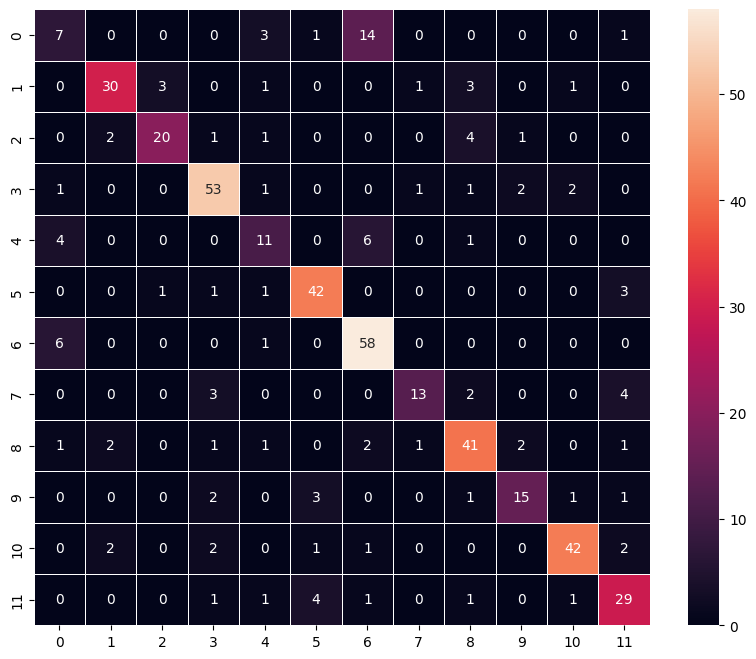

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

# Model 1 performance
- model is good but can be improved by making a few twaeks which include changing the dropout
- also changing the filter sizes
- performing data augmentation
- using transfer learning architectures

# Model-2

## **Data Augmentation**

In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is **Data Augmentation**. CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. <br> Taking this attribute into account, we can augment the images using the techniques listed below - <br>
**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )
#test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
# Intializing a sequential model
model_3 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model_3.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model_3.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
# Adding max pooling to reduce the size of output of first conv layer
model_3.add(MaxPooling2D((2, 2), padding = 'same'))

model_3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_3.add(MaxPooling2D((2, 2), padding = 'same'))
model_3.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model_3.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model_3.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_3.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.3))
model_3.add(Dense(64, activation='relu'))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model_3.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model_3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 11s 104ms/step - loss: 2.4356 - accuracy: 0.1266 - val_loss: 2.4211 - val_accuracy: 0.1379
Epoch 2/25
60/60 [==============================] - 4s 72ms/step - loss: 2.2463 - accuracy: 0.2213 - val_loss: 1.8196 - val_accuracy: 0.3808
Epoch 3/25
60/60 [==============================] - 4s 74ms/step - loss: 1.7166 - accuracy: 0.3918 - val_loss: 1.4789 - val_accuracy: 0.4603
Epoch 4/25
60/60 [==============================] - 5s 91ms/step - loss: 1.4749 - accuracy: 0.4676 - val_loss: 1.2668 - val_accuracy: 0.5654
Epoch 5/25
60/60 [==============================] - 4s 74ms/step - loss: 1.2991 - accuracy: 0.5414 - val_loss: 1.2734 - val_accuracy: 0.5794
Epoch 6/25
60/60 [==============================] - 6s 95ms/step - loss: 1.1816 - accuracy: 0.5850 - val_loss: 1.0670 - val_accuracy: 0.6589
Epoch 7/25
60/60 [==============================] - 5s 85ms/step - loss: 1.0727 - accuracy: 0.6143 - val_loss: 0.9691 - val_accuracy: 0.6893
Epoch 8/25


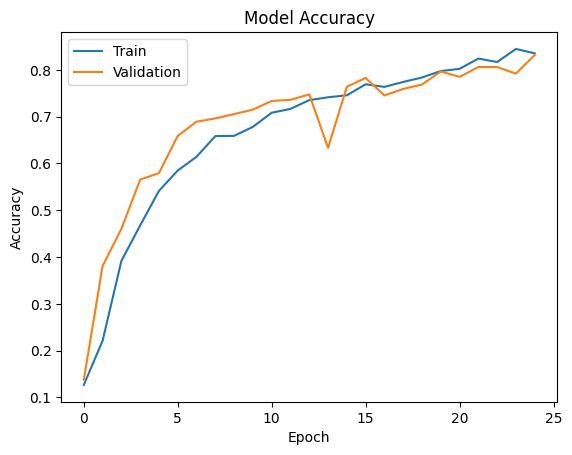

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**


*   We can see from the above plot that **the training and validation accuracy of the model was good  .**
*   The model doesnt overfit on the data.


### **Evaluating the model on test data**

In [ ]:
accuracy = model_3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.5939 - accuracy: 0.8105 - 168ms/epoch - 11ms/step


### **Generating the predictions using test data**

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model_3.predict(X_test_normalized)

15/15 [==============================] - 0s 5ms/step


In [ ]:
y_pred

array([[4.71611727e-09, 1.18768395e-09, 2.38706410e-09, ...,
        6.51420623e-06, 1.53927502e-08, 5.87424211e-07],
       [4.40224893e-17, 2.94958008e-04, 3.29610657e-06, ...,
        3.91706322e-07, 9.99698520e-01, 1.25629455e-11],
       [1.46678971e-11, 2.93183462e-06, 2.08350826e-07, ...,
        4.50209291e-06, 9.99973536e-01, 5.21655075e-08],
       ...,
       [2.75066406e-01, 2.97372278e-08, 8.80837888e-06, ...,
        6.01029413e-08, 3.25931666e-07, 9.58066039e-07],
       [2.80519941e-09, 2.77604213e-05, 2.40968904e-04, ...,
        1.19840488e-01, 2.68326517e-07, 1.86390214e-04],
       [4.73014098e-14, 5.50048435e-06, 3.81049681e-09, ...,
        5.46947896e-01, 2.77379172e-06, 8.87110291e-05]], dtype=float32)

### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.

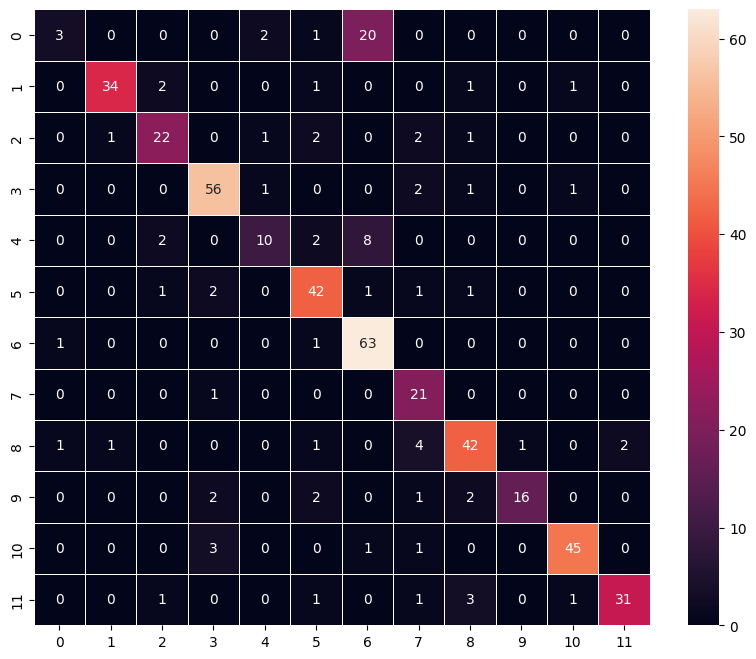

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

# Transfer Learning using VGG16

In [ ]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
model_4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_4.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_4.add(Flatten())

# Adding a dense output layer
model_4.add(Dense(32, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
model_4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                65568     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 12)                204       
                                                                 
Total params: 14,780,988
Trainable params: 66,300
Non-

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history_vgg16 = model_4.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 10s 124ms/step - loss: 2.3819 - accuracy: 0.1644 - val_loss: 2.2586 - val_accuracy: 0.2827
Epoch 2/25
60/60 [==============================] - 5s 77ms/step - loss: 2.1709 - accuracy: 0.2712 - val_loss: 2.0446 - val_accuracy: 0.3762
Epoch 3/25
60/60 [==============================] - 6s 103ms/step - loss: 1.9579 - accuracy: 0.3431 - val_loss: 1.8623 - val_accuracy: 0.3668
Epoch 4/25
60/60 [==============================] - 5s 78ms/step - loss: 1.7986 - accuracy: 0.3777 - val_loss: 1.7707 - val_accuracy: 0.3879
Epoch 5/25
60/60 [==============================] - 5s 79ms/step - loss: 1.7047 - accuracy: 0.3984 - val_loss: 1.6618 - val_accuracy: 0.3972
Epoch 6/25
60/60 [==============================] - 7s 112ms/step - loss: 1.6284 - accuracy: 0.4272 - val_loss: 1.6107 - val_accuracy: 0.4439
Epoch 7/25
60/60 [==============================] - 5s 82ms/step - loss: 1.5909 - accuracy: 0.4330 - val_loss: 1.5527 - val_accuracy: 0.4556
Epoch 8/2

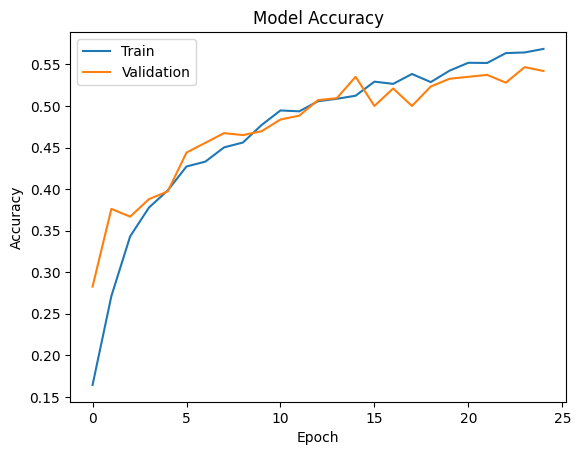

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model_4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.3009 - accuracy: 0.5600 - 710ms/epoch - 47ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=model_4.predict(X_test_normalized)

15/15 [==============================] - 1s 19ms/step


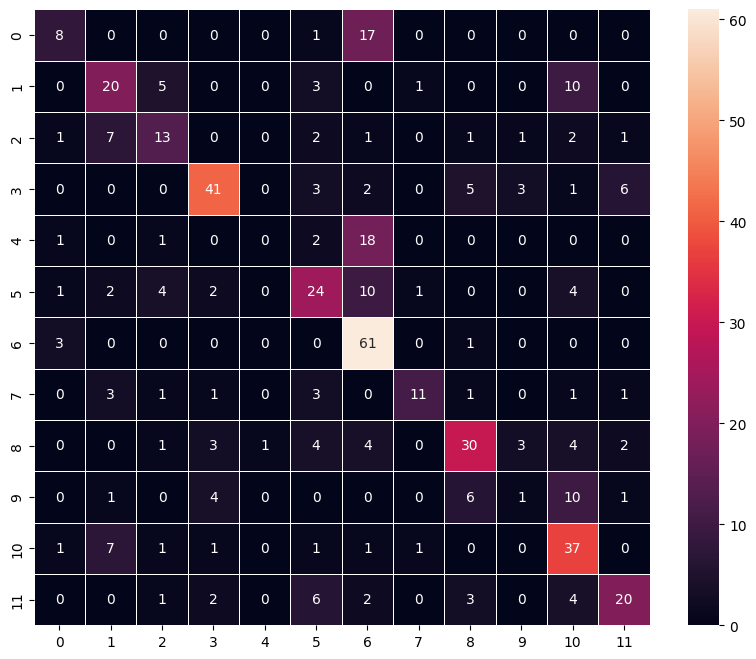

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

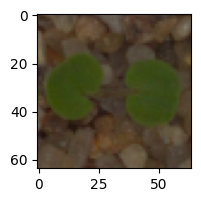

1/1 [==============================] - 0s 395ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


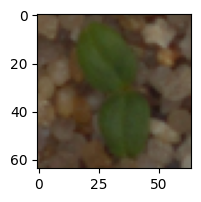

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Fat Hen']
True Label Cleavers


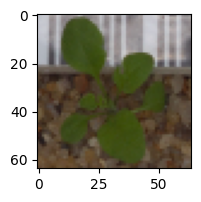

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Charlock']
True Label Shepherds Purse


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', lb.inverse_transform(model_4.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', lb.inverse_transform(model_4.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', lb.inverse_transform(model_4.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

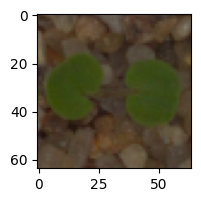

1/1 [==============================] - 0s 140ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


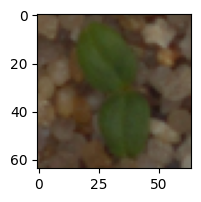

1/1 [==============================] - 0s 24ms/step
Predicted Label ['Cleavers']
True Label Cleavers


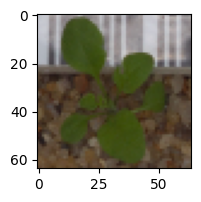

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', lb.inverse_transform(model_3.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', lb.inverse_transform(model_3.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', lb.inverse_transform(model_3.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

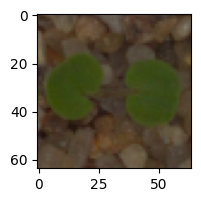

1/1 [==============================] - 0s 99ms/step
Predicted Label ['Common Chickweed']
True Label Small-flowered Cranesbill


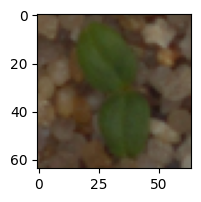

1/1 [==============================] - 0s 22ms/step
Predicted Label ['Common wheat']
True Label Cleavers


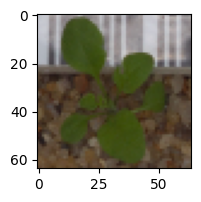

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Common wheat']
True Label Shepherds Purse


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', lb.inverse_transform(model_2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', lb.inverse_transform(model_2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', lb.inverse_transform(model_2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

### key observations
- dataset is imbalanced which could affect the model
- Data Augmentation has also helped in improving the second model.
- there are 4750 images. (No missing data)

In [ ]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['91%','83%','56%'],'Validation Accuracy':['74%','83%','54%'],'Test Accuracy':['76%','81%','56%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,91%,74%,76%
1,CNN Model with Data Augmentation,83%,83%,81%
2,Transfer Learning Model,56%,54%,56%


## Model Performance Improvement
- All these models can be improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64, this would impact the accuracy of the algorithm
- Data Augmentation can be performed more and dropout_rate can be changed just as i did by 0.05 to improve the model performance in the second model.
- Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.

## **Conclusion**
- We can observe from the confusion matrix of all the models that our 2nd model was the best model because it predicted the majority of the classes better than the other models.
- The test accuracy of the model_2 is 76%.
- The test accuracy of the model_3 is 81%.
- The test accuracy of the VGG16 model is 63%